In [95]:
import networkx as nx
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv("../data/ecoli_ppi_Hu_etal_2009.txt", header=None,names=["source", "target"], sep=" ")

# 重複、自己ループの確認
print("original shape: ",df.shape)
print("num duplicates: ", df.drop_duplicates().shape)
print("num self loop: ", df.query("source == target").shape)

original shape:  (5993, 2)
num duplicates:  (5993, 2)
num self loop:  (0, 2)


In [43]:
g = nx.from_pandas_edgelist(df)

In [80]:
degree = nx.degree_centrality(g)
eigen = nx.eigenvector_centrality_numpy(g)
page = nx.pagerank_numpy(g)
closen = nx.closeness_centrality(g)
between = nx.betweenness_centrality(g)
subgraph = nx.subgraph_centrality(g)

In [72]:
nprop = pd.DataFrame([degree, eigen, page, closen, between, subgraph]).T
nprop.columns = ["degree", "eigen", "page", "closen", "between", "subgraph"]

In [73]:
ess = pd.read_csv("../data/ecoli_proteins_essentiality_Baba2006MSB.txt", sep=" ")

In [89]:
df = pd.merge(ess, nprop, left_on="gene", right_index=True)
df = df[df["essential"] != 'u'].reset_index()

In [90]:
df.head()

,index,gene,essential,degree,eigen,page,closen,between,subgraph
0,1,b0002,N,0.001139,0.000612,0.000256,0.229430,0.000032,4.138384e+09
1,3,b0004,N,0.003417,0.004852,0.000465,0.258277,0.000615,2.601425e+11
2,7,b0008,N,0.006264,0.006616,0.000709,0.260687,0.000351,4.836786e+11
3,8,b0009,N,0.000569,0.000559,0.000141,0.225530,0.000000,3.457115e+09
4,14,b0015,N,0.033030,0.073207,0.003433,0.329474,0.018787,5.921484e+13


/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<AxesSubplot:xlabel='essential', ylabel='subgraph'>

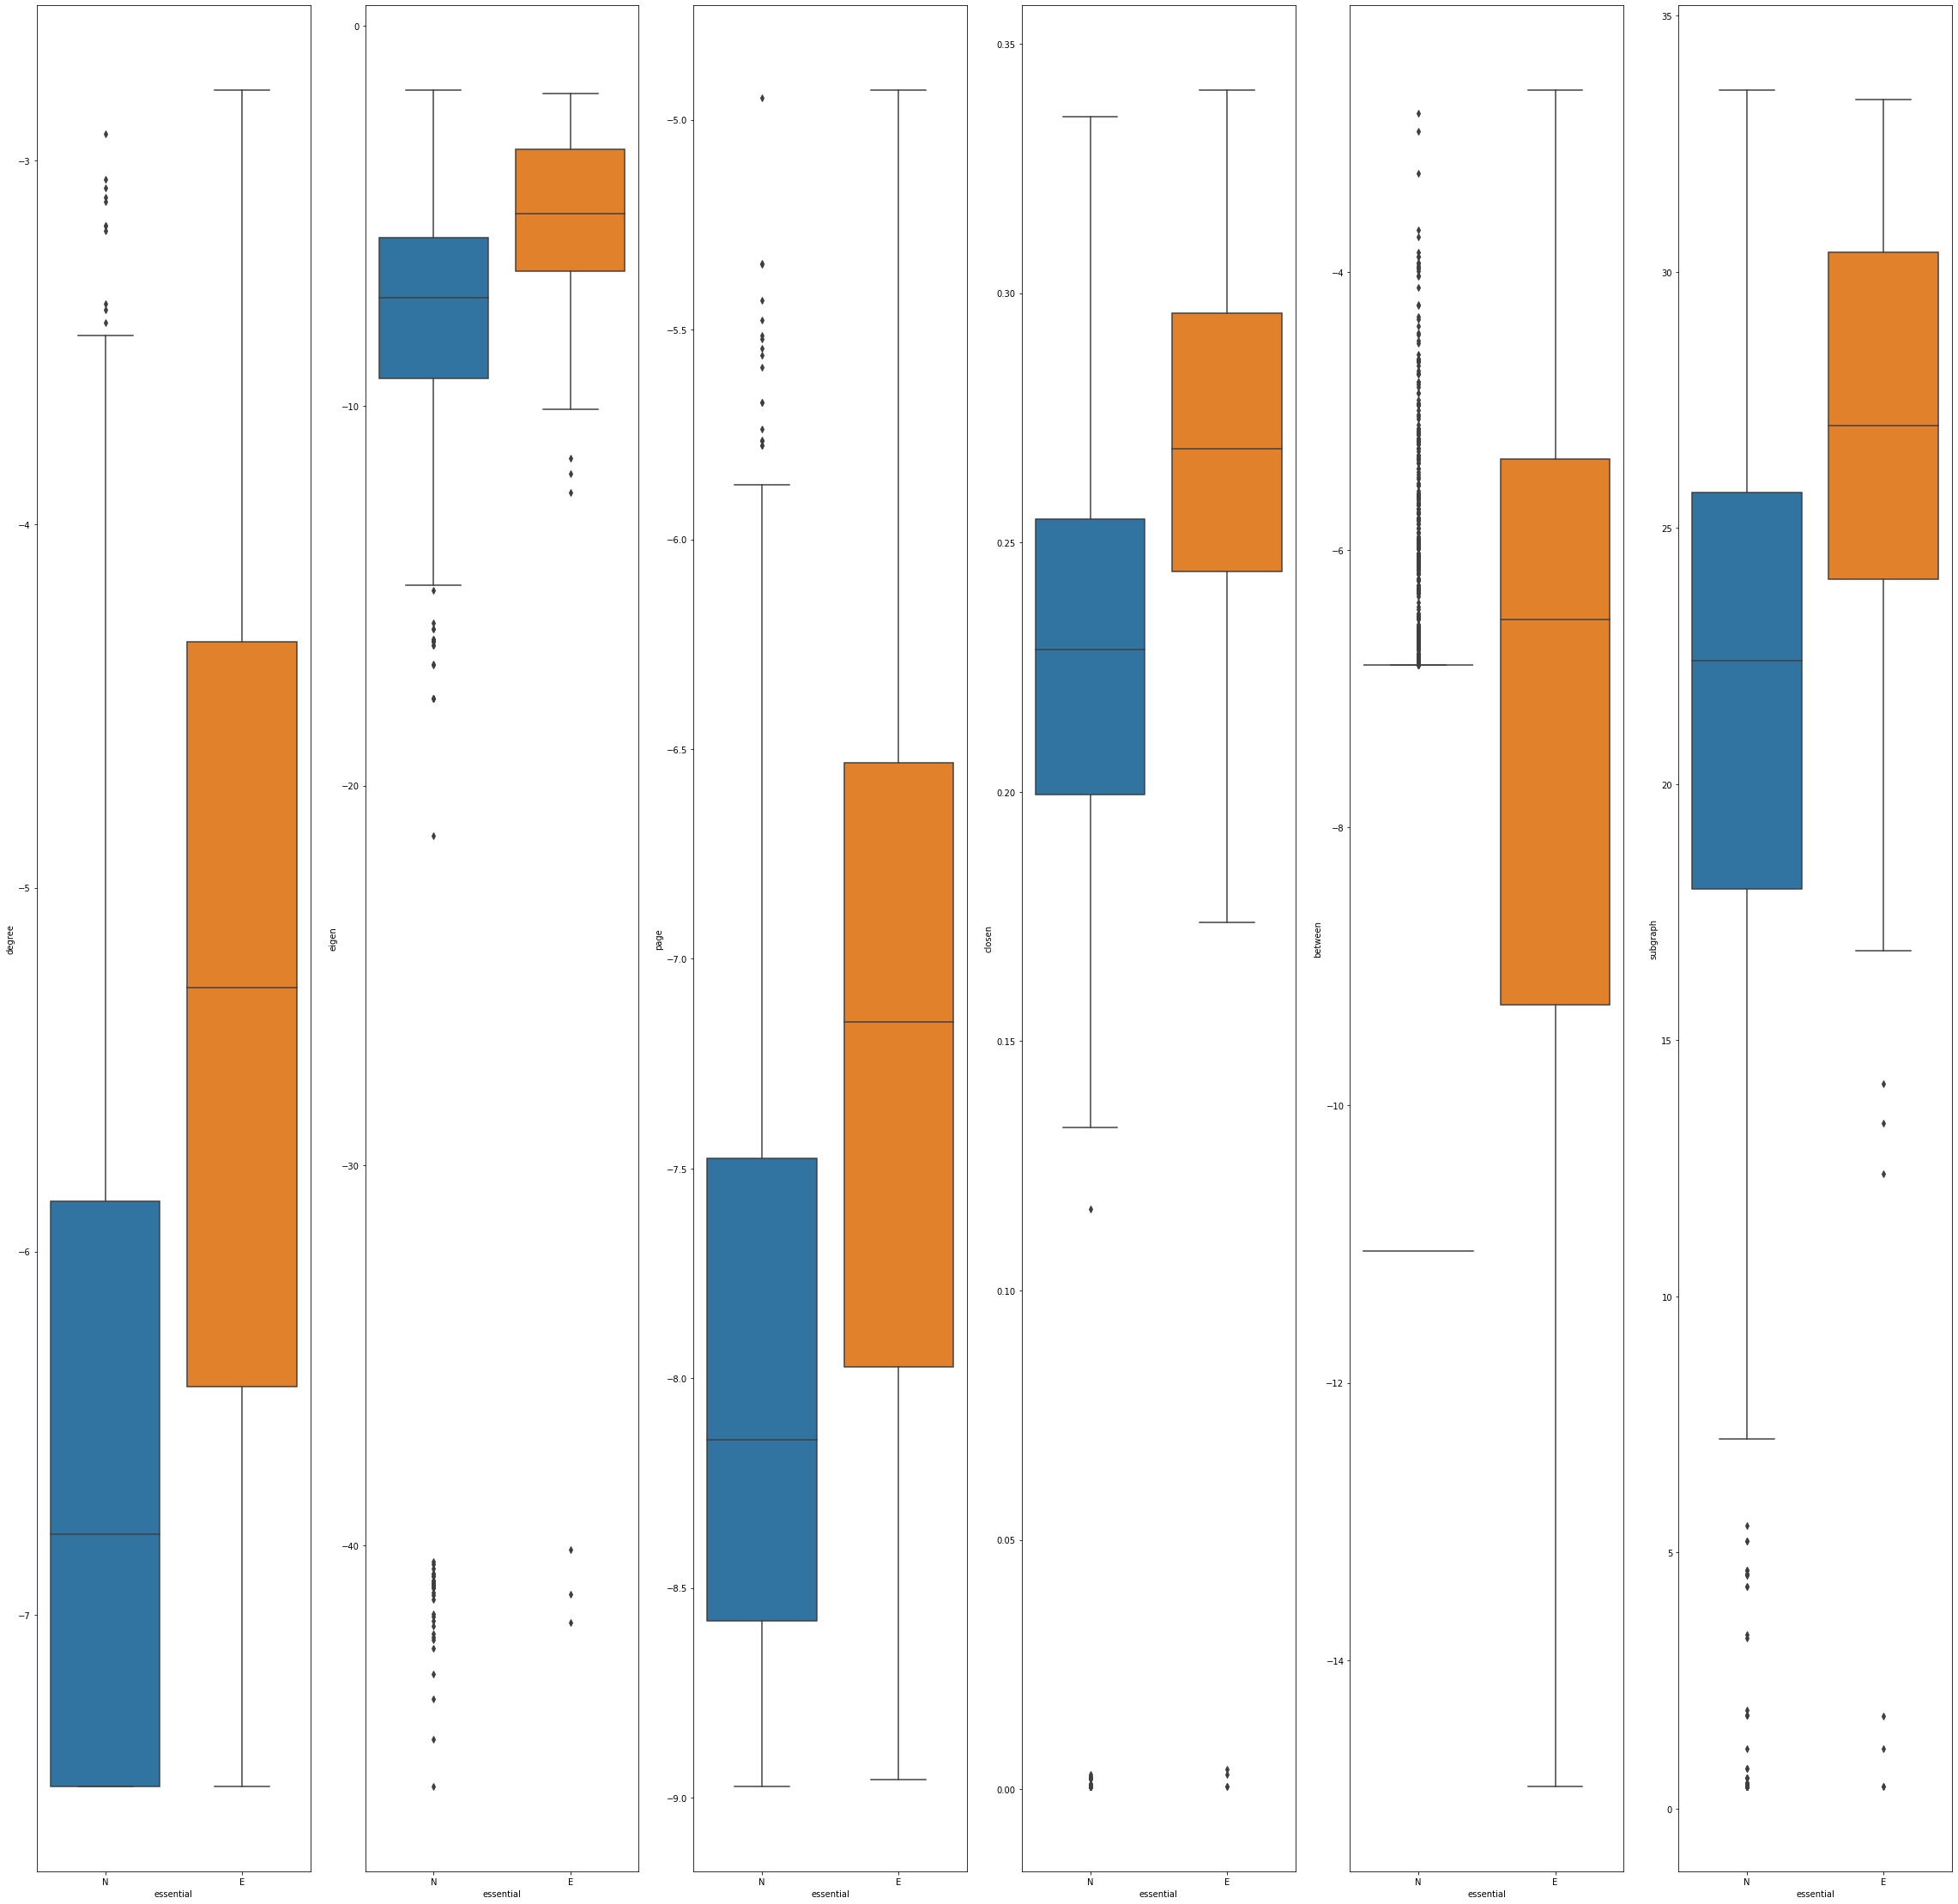

In [102]:
fig, (ax) = plt.subplots(1, 6, figsize=(40, 40))

sns.boxplot(y=np.log(df["degree"]), x=df["essential"], ax=ax[0])
sns.boxplot(y=np.log(df["eigen"]), x=df["essential"], ax=ax[1])
sns.boxplot(y=np.log(df["page"]), x=df["essential"], ax=ax[2])
sns.boxplot(y=df["closen"], x=df["essential"], ax=ax[3])
sns.boxplot(y=np.log(df["between"]), x=df["essential"], ax=ax[4])
sns.boxplot(y=np.log(df["subgraph"]), x=df["essential"], ax=ax[5])
